#Utilities

In [1]:
import contextlib
import copy
import inspect
from collections import OrderedDict
import torch
import requests

In [2]:
def get_module(model, name):
    """
    Finds the named module within the given model.
    """
    for n, m in model.named_modules():
        if n == name:
            return m
    raise LookupError(name)

def replace_module(model, name, new_module):
    """
    Replaces the named module within the given model.
    """
    if "." in name:
        parent_name, attr_name = name.rsplit(".", 1)
        model = get_module(model, parent_name)
    # original_module = getattr(model, attr_name)
    setattr(model, attr_name, new_module)

class StopForward(Exception):
    """
    If the only output needed from running a network is the retained
    submodule then Trace(submodule, stop=True) will stop execution
    immediately after the retained submodule by raising the StopForward()
    exception.  When Trace is used as context manager, it catches that
    exception and can be used as follows:

    with Trace(net, layername, stop=True) as tr:
        net(inp) # Only runs the network up to layername
    print(tr.output)
    """

    pass

def recursive_copy(x, clone=None, detach=None, retain_grad=None):
    """
    Copies a reference to a tensor, or an object that contains tensors,
    optionally detaching and cloning the tensor(s).  If retain_grad is
    true, the original tensors are marked to have grads retained.
    """
    if not clone and not detach and not retain_grad:
        return x
    if isinstance(x, torch.Tensor):
        if retain_grad:
            if not x.requires_grad:
                x.requires_grad = True
            x.retain_grad()
        elif detach:
            x = x.detach()
        if clone:
            x = x.clone()
        return x
    # Only dicts, lists, and tuples (and subclasses) can be copied.
    if isinstance(x, dict):
        return type(x)({k: recursive_copy(v) for k, v in x.items()})
    elif isinstance(x, (list, tuple)):
        return type(x)([recursive_copy(v) for v in x])
    else:
        assert False, f"Unknown type {type(x)} cannot be broken into tensors."

def invoke_with_optional_args(fn, *args, **kwargs):
    """
    Invokes a function with only the arguments that it
    is written to accept, giving priority to arguments
    that match by-name, using the following rules.
    (1) arguments with matching names are passed by name.
    (2) remaining non-name-matched args are passed by order.
    (3) extra caller arguments that the function cannot
        accept are not passed.
    (4) extra required function arguments that the caller
        cannot provide cause a TypeError to be raised.
    Ordinary python calling conventions are helpful for
    supporting a function that might be revised to accept
    extra arguments in a newer version, without requiring the
    caller to pass those new arguments.  This function helps
    support function callers that might be revised to supply
    extra arguments, without requiring the callee to accept
    those new arguments.
    """
    argspec = inspect.getfullargspec(fn)
    pass_args = []
    used_kw = set()
    unmatched_pos = []
    used_pos = 0
    defaulted_pos = len(argspec.args) - (
        0 if not argspec.defaults else len(argspec.defaults)
    )
    # Pass positional args that match name first, then by position.
    for i, n in enumerate(argspec.args):
        if n in kwargs:
            pass_args.append(kwargs[n])
            used_kw.add(n)
        elif used_pos < len(args):
            pass_args.append(args[used_pos])
            used_pos += 1
        else:
            unmatched_pos.append(len(pass_args))
            pass_args.append(
                None if i < defaulted_pos else argspec.defaults[i - defaulted_pos]
            )
    # Fill unmatched positional args with unmatched keyword args in order.
    if len(unmatched_pos):
        for k, v in kwargs.items():
            if k in used_kw or k in argspec.kwonlyargs:
                continue
            pass_args[unmatched_pos[0]] = v
            used_kw.add(k)
            unmatched_pos = unmatched_pos[1:]
            if len(unmatched_pos) == 0:
                break
        else:
            if unmatched_pos[0] < defaulted_pos:
                unpassed = ", ".join(
                    argspec.args[u] for u in unmatched_pos if u < defaulted_pos
                )
                raise TypeError(f"{fn.__name__}() cannot be passed {unpassed}.")
    # Pass remaining kw args if they can be accepted.
    pass_kw = {
        k: v
        for k, v in kwargs.items()
        if k not in used_kw and (k in argspec.kwonlyargs or argspec.varargs is not None)
    }
    # Pass remaining positional args if they can be accepted.
    if argspec.varargs is not None:
        pass_args += list(args[used_pos:])
    return fn(*pass_args, **pass_kw)



def set_requires_grad(requires_grad, *models):
    """
    Sets requires_grad true or false for all parameters within the
    models passed.
    """
    for model in models:
        if isinstance(model, torch.nn.Module):
            for param in model.parameters():
                param.requires_grad = requires_grad
        elif isinstance(model, (torch.nn.Parameter, torch.Tensor)):
            model.requires_grad = requires_grad
        else:
            assert False, "unknown type %r" % type(model)


In [3]:
class Trace(contextlib.AbstractContextManager):
    """
    To retain the output of the named layer during the computation of
    the given network:

        with Trace(net, 'layer.name') as ret:
            _ = net(inp)
            representation = ret.output

    A layer module can be passed directly without a layer name, and
    its output will be retained.  By default, a direct reference to
    the output object is returned, but options can control this:

        clone=True  - retains a copy of the output, which can be
            useful if you want to see the output before it might
            be modified by the network in-place later.
        detach=True - retains a detached reference or copy.  (By
            default the value would be left attached to the graph.)
        retain_grad=True - request gradient to be retained on the
            output.  After backward(), ret.output.grad is populated.

        retain_input=True - also retains the input.
        retain_output=False - can disable retaining the output.
        edit_output=fn - calls the function to modify the output
            of the layer before passing it the rest of the model.
            fn can optionally accept (output, layer) arguments
            for the original output and the layer name.
        stop=True - throws a StopForward exception after the layer
            is run, which allows running just a portion of a model.
    """


    def __init__(
        self,
        module,
        layer=None,
        retain_output=True,
        retain_input=False,
        clone=False,
        detach=False,
        retain_grad=False,
        edit_output=None,
        stop=False,
    ):
        """
        Method to replace a forward method with a closure that
        intercepts the call, and tracks the hook so that it can be reverted.
        """
        retainer = self
        self.layer = layer
        if layer is not None:
            module = get_module(module, layer)

        def retain_hook(m, inputs, output):
            if retain_input:
                retainer.input = recursive_copy(
                    inputs[0] if len(inputs) == 1 else inputs,
                    clone=clone,
                    detach=detach,
                    retain_grad=False,
                )  # retain_grad applies to output only.
            if edit_output:
                output = invoke_with_optional_args(
                    edit_output, output=output, layer=self.layer
                )
            if retain_output:
                retainer.output = recursive_copy(
                    output, clone=clone, detach=detach, retain_grad=retain_grad
                )
                # When retain_grad is set, also insert a trivial
                # copy operation.  That allows in-place operations
                # to follow without error.
                if retain_grad:
                    output = recursive_copy(retainer.output, clone=True, detach=False)
            if stop:
                raise StopForward()
            return output

        self.registered_hook = module.register_forward_hook(retain_hook)
        self.stop = stop

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()
        if self.stop and issubclass(type, StopForward):
            return True

    def close(self):
        self.registered_hook.remove()



In [4]:
class TraceDict(OrderedDict, contextlib.AbstractContextManager):
    """
    To retain the output of multiple named layers during the computation
    of the given network:

        with TraceDict(net, ['layer1.name1', 'layer2.name2']) as ret:
            _ = net(inp)
            representation = ret['layer1.name1'].output

    If edit_output is provided, it should be a function that takes
    two arguments: output, and the layer name; and then it returns the
    modified output.

    Other arguments are the same as Trace.  If stop is True, then the
    execution of the network will be stopped after the last layer
    listed (even if it would not have been the last to be executed).
    """

    def __init__(
        self,
        model,
        layers=None,
        retain_output=True,
        retain_input=False,
        clone=False,
        detach=False,
        retain_grad=False,
        edit_output=None,
        stop=False,
    ):
        self.stop = stop

        def flag_last_unseen(it):
            try:
                it = iter(it)
                prev = next(it)
                seen = set([prev])
            except StopIteration:
                return
            for item in it:
                if item not in seen:
                    yield False, prev
                    seen.add(item)
                    prev = item
            yield True, prev

        for is_last, layer in flag_last_unseen(layers):
            self[layer] = Trace(
                module=model,
                layer=layer,
                retain_output=retain_output,
                retain_input=retain_input,
                clone=clone,
                detach=detach,
                retain_grad=retain_grad,
                edit_output=edit_output,
                stop=stop and is_last,
            )

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()
        if self.stop and issubclass(type, StopForward):
            return True

    def close(self):
        for layer, trace in reversed(self.items()):
            trace.close()

#Library Imports

In [5]:
!pip install transformers

In [6]:
import os, re, json
import torch, numpy
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import itertools
import nltk
import random
# from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
#import stanza
#import datasets
import scipy
import csv
import pandas as pd
from PIL import Image
from typing import Any, Optional, Tuple, Union,OrderedDict

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Main

###Model Initialization

In [8]:
from transformers import BlipForQuestionAnswering,BlipProcessor
model= BlipForQuestionAnswering.from_pretrained('Salesforce/blip-vqa-base')
processor=BlipProcessor.from_pretrained('Salesforce/blip-vqa-base')

model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [9]:
model_name='Salesforce/blip-vqa-base'

In [10]:
class ModelandProcessor:
  def __init__(
        self,
        model_name=None,
        model=None,
        processor=None,
        low_cpu_mem_usage=False,
        torch_dtype=None,
    ):
        if  processor is None:
            assert model_name is not None
            processor = BlipProcessor.from_pretrained(model_name)
        if model is None:
            assert model_name is not None
            model = BlipForQuestionAnswering.from_pretrained(
                model_name, low_cpu_mem_usage=low_cpu_mem_usage, torch_dtype=torch_dtype
            )
            set_requires_grad(False, model)
            model.eval().cuda()
        self.processor = processor
        self.model = model
        self.layer_names = [
            n
            for n, m in model.named_modules()
            if (re.match(r"^(vision_model|text_encoder|text_decoder.bert|text_decoder.cls)\.(embeddings|encoder.layers|encoder.layer|predictions)\.(\d+$)", n))
        ]
        self.num_layers = (len(self.layer_names)//3)

  def __repr__(self):
        return (
            f"ModelAndTokenizer(model: {type(self.model).__name__} "
            f"[{self.num_layers} layers], "
            f"tokenizer: {type(self.tokenizer).__name__})"
        )


In [11]:
mt=ModelandProcessor(model_name,model,processor)

In [12]:
(mt.num_layers)

12

In [13]:
def layername(model, num,block_name, kind=None):
  if block_name=="text_encoder":
    if hasattr(model,"model_text_enc"):
        if kind == "embed":
            return "model_text_enc.embeddings"
        return f'model_text_enc.encoder.layer.{num}{"" if kind is None else "." + kind}'
  elif block_name=="text_decoder":
    if hasattr(model,"model_text_dec"):
        if kind == "embed":
            return f'model_text_dec.bert.embeddings'
        elif kind=="cls.decoder":
            return f'text_decoder.cls.predictions.decoder'
        return f'model_text_dec.bert.encoder.layer.{num}{"" if kind is None else "." + kind}'
    assert False, "unknown transformer structure"

In [14]:
from transformers import BlipConfig

In [15]:
class ModelOutput(OrderedDict):
    """
    Base class for all model outputs as dataclass. Has a `__getitem__` that allows indexing by integer or slice (like a
    tuple) or strings (like a dictionary) that will ignore the `None` attributes. Otherwise behaves like a regular
    python dictionary.

    <Tip warning={true}>

    You can't unpack a `ModelOutput` directly. Use the [`~utils.ModelOutput.to_tuple`] method to convert it to a tuple
    before.

    </Tip>
    """

    def __post_init__(self):
        class_fields = fields(self)

        # Safety and consistency checks
        if not len(class_fields):
            raise ValueError(f"{self.__class__.__name__} has no fields.")
        if not all(field.default is None for field in class_fields[1:]):
            raise ValueError(f"{self.__class__.__name__} should not have more than one required field.")

        first_field = getattr(self, class_fields[0].name)
        other_fields_are_none = all(getattr(self, field.name) is None for field in class_fields[1:])

        if other_fields_are_none and not is_tensor(first_field):
            if isinstance(first_field, dict):
                iterator = first_field.items()
                first_field_iterator = True
            else:
                try:
                    iterator = iter(first_field)
                    first_field_iterator = True
                except TypeError:
                    first_field_iterator = False

            # if we provided an iterator as first field and the iterator is a (key, value) iterator
            # set the associated fields
            if first_field_iterator:
                for idx, element in enumerate(iterator):
                    if (
                        not isinstance(element, (list, tuple))
                        or not len(element) == 2
                        or not isinstance(element[0], str)
                    ):
                        if idx == 0:
                            # If we do not have an iterator of key/values, set it as attribute
                            self[class_fields[0].name] = first_field
                        else:
                            # If we have a mixed iterator, raise an error
                            raise ValueError(
                                f"Cannot set key/value for {element}. It needs to be a tuple (key, value)."
                            )
                        break
                    setattr(self, element[0], element[1])
                    if element[1] is not None:
                        self[element[0]] = element[1]
            elif first_field is not None:
                self[class_fields[0].name] = first_field
        else:
            for field in class_fields:
                v = getattr(self, field.name)
                if v is not None:
                    self[field.name] = v

    def __delitem__(self, *args, **kwargs):
        raise Exception(f"You cannot use ``__delitem__`` on a {self.__class__.__name__} instance.")

    def setdefault(self, *args, **kwargs):
        raise Exception(f"You cannot use ``setdefault`` on a {self.__class__.__name__} instance.")

    def pop(self, *args, **kwargs):
        raise Exception(f"You cannot use ``pop`` on a {self.__class__.__name__} instance.")

    def update(self, *args, **kwargs):
        raise Exception(f"You cannot use ``update`` on a {self.__class__.__name__} instance.")

    def __getitem__(self, k):
        if isinstance(k, str):
            inner_dict = dict(self.items())
            return inner_dict[k]
        else:
            return self.to_tuple()[k]

    def __setattr__(self, name, value):
        if name in self.keys() and value is not None:
            # Don't call self.__setitem__ to avoid recursion errors
            super().__setitem__(name, value)
        super().__setattr__(name, value)

    def __setitem__(self, key, value):
        # Will raise a KeyException if needed
        super().__setitem__(key, value)
        # Don't call self.__setattr__ to avoid recursion errors
        super().__setattr__(key, value)

    def to_tuple(self) -> Tuple[Any]:
        """
        Convert self to a tuple containing all the attributes/keys that are not `None`.
        """
        return tuple(self[k] for k in self.keys())

In [16]:
class BlipVQAOutput(ModelOutput):
    """
    Adapted from the base class for vision model's outputs that also contains image embeddings of the pooling of the
    last hidden states. This class also adds the loss term from the text decoder.

    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Languge modeling loss from the text decoder.
        image_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim)` *optional* returned when model is initialized with `with_projection=True`):
            The image embeddings obtained by applying the projection layer to the pooler_output.
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """
    decoder_logits:Optional[Tuple[torch.FloatTensor]] = None
    image_embeds: Optional[torch.FloatTensor] = None
    vision_last_hidden_state: torch.FloatTensor=None
    encoder_last_hidden_state: torch.FloatTensor = None
    encoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    decoder_last_hidden_state: torch.FloatTensor = None
    decoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None




In [17]:
class customblip_temp(torch.nn.Module):
  def __init__(self,model):
        super(customblip_temp, self).__init__()
        self.model_vis = model.vision_model
        self.model_text_enc = model.text_encoder
        self.model_text_dec = model.text_decoder
        self.decoder_pad_token_id = model.decoder_pad_token_id
        self.decoder_start_token_id = model.decoder_start_token_id
        self.eos_token_id=model.config.text_config.sep_token_id,
        self.pad_token_id=model.config.text_config.pad_token_id
        self.output_attentions=model.config.output_attentions
        self.use_return_dict=model.config.use_return_dict
        self.output_hidden_states=model.config.output_hidden_states

  def image_embed(
      self,
        list_pixel_values: torch.FloatTensor,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
    ):
    image_embeds_tensor=torch.zeros(size=(len(list_pixel_values),577,768))
    for i in range(len(list_pixel_values)):
      vision_outputs = self.model_vis(
              pixel_values=list_pixel_values[i],
              output_attentions=output_attentions,
              output_hidden_states=output_hidden_states,
          )
      image_embeds = vision_outputs[0]
      image_embeds_tensor[i,:,:]=image_embeds[0]

    return image_embeds_tensor
  def forward(
        self,
        input_ids: torch.LongTensor,
        image_embeds: Optional[torch.FloatTensor]=None,
        attention_mask: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BlipVQAOutput]:

        return_dict = return_dict if return_dict is not None else self.use_return_dict
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )

        if image_embeds!=None:
          image_embeds=image_embeds.to(device)
          image_embeds_w=image_embeds
          image_attention_mask = torch.ones(image_embeds_w.size()[:-1], dtype=torch.long)

        input_ids=input_ids.to(device)
        question_embeds = self.model_text_enc(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=image_embeds_w,
            encoder_attention_mask=image_attention_mask,
            output_hidden_states=True,
        )

        question_embeds_w = question_embeds[0] if not return_dict else question_embeds.last_hidden_state

        bos_ids = torch.full(
            (question_embeds_w.size(0), 1), fill_value=self.decoder_start_token_id, device=(device)
        )

        answer_output = self.model_text_dec(
            input_ids=bos_ids,
            encoder_hidden_states=question_embeds_w,
            encoder_attention_mask=attention_mask,
            output_hidden_states=True,
            reduction="mean"
        )


        return BlipVQAOutput(
            decoder_logits=answer_output.logits,
            image_embeds=image_embeds_w,
            encoder_last_hidden_state=question_embeds.last_hidden_state,
            encoder_hidden_states=question_embeds.hidden_states,
            decoder_hidden_states=answer_output.hidden_states,
        )

In [18]:
new_model=customblip_temp(model)

In [19]:
new_model.to(device)

customblip_temp(
  (model_vis): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, elementwise_a

In [20]:
for n,m in new_model.named_modules():
  print(n)


model_vis
model_vis.embeddings
model_vis.embeddings.patch_embedding
model_vis.encoder
model_vis.encoder.layers
model_vis.encoder.layers.0
model_vis.encoder.layers.0.self_attn
model_vis.encoder.layers.0.self_attn.dropout
model_vis.encoder.layers.0.self_attn.qkv
model_vis.encoder.layers.0.self_attn.projection
model_vis.encoder.layers.0.layer_norm1
model_vis.encoder.layers.0.mlp
model_vis.encoder.layers.0.mlp.activation_fn
model_vis.encoder.layers.0.mlp.fc1
model_vis.encoder.layers.0.mlp.fc2
model_vis.encoder.layers.0.layer_norm2
model_vis.encoder.layers.1
model_vis.encoder.layers.1.self_attn
model_vis.encoder.layers.1.self_attn.dropout
model_vis.encoder.layers.1.self_attn.qkv
model_vis.encoder.layers.1.self_attn.projection
model_vis.encoder.layers.1.layer_norm1
model_vis.encoder.layers.1.mlp
model_vis.encoder.layers.1.mlp.activation_fn
model_vis.encoder.layers.1.mlp.fc1
model_vis.encoder.layers.1.mlp.fc2
model_vis.encoder.layers.1.layer_norm2
model_vis.encoder.layers.2
model_vis.encoder

###Noise Addition

In [21]:
import requests

In [22]:
def make_inputs(ModelandProcessor,new_model,image,question, device=device):
  d_temp={}
  model=ModelandProcessor.model
  processor=ModelandProcessor.processor

  input_ids = processor(text=question, return_tensors='pt').input_ids.to(device)
  #input_ids = (torch.tensor(input_ids).unsqueeze(0)).to(device)

  pixel_values=processor(images=image,return_tensors="pt")
  pixel_values_1=pixel_values.pixel_values.to(device)
  pixel_values_2=pixel_values.pixel_values.to(device)
  l=[pixel_values_1,pixel_values_2]

  image_embeds=new_model.image_embed(list_pixel_values=l)
  image_embeds.to(device)

  tup=(image_embeds,input_ids)
  return tup



In [23]:
def predict_from_input(new_model,tup):
    image_embeds,input_ids=tup
    output=new_model.forward(image_embeds=image_embeds.to(device),input_ids=input_ids.to(device))


    #attention_mask=processor(text=text_input, add_special_tokens=False).attention_mask

    return output

In [24]:
def result_gen(output, return_p=False):
    out=output['decoder_logits']
    probs = torch.softmax(out[:, -1], dim=1)
    p, preds = torch.max(probs, dim=1)
    return preds, p

In [25]:
def decoding(mt,pred_prob):
  preds=pred_prob[0]
  ans=[]
  for i in range(preds.size(0)):
    single_pred=preds[i]
    decoded_answer=processor.decode(single_pred, skip_special_tokens=True)
    ans.append(decoded_answer)
  return ans[0]



In [26]:
def prng(shape: tuple, uniform_noise: bool = True) -> np.ndarray:
      rs = np.random.RandomState(1)
      if uniform_noise:
        return rs.uniform(-1, 1, shape)
      else:
        return rs.randn(*shape)

In [28]:
def noisy_embedding(image_embed_tensor,noise=5,percentage_dimensions=1):
  eps=torch.normal(mean=1,std=noise,size=(image_embed_tensor[1].shape))
  image_embed_tensor[1]=image_embed_tensor[1]*eps
  image_embed_tensor.to(device)
  return(image_embed_tensor)


In [ ]:
# def noisy_embedding(image_embed_tensor,uniform_noise=True,noise=0.95,percentage_dimensions=1):
#   #num_dimensions_to_corrupt=round(percentage_dimensions*(inp[0].shape[0]))
#   corrupt_indices = [i for i in range(0,image_embed_tensor.size(1))]
#   if isinstance(noise, float):
#         noise_fn = lambda inp: noise * inp
#   else:
#         noise_fn = noise


#   noise_data = torch.rand(size=[1,577,768])
#   corrupt_run=image_embed_tensor[1][:,:]
#   image_embed_tensor[1]=noise_fn(image_embed_tensor[1])
#   image_embed_tensor.to(device)
#   return image_embed_tensor

In [29]:
def trace_with_patch(
    mt,new_model,  # The model
    image,
    question,  # A set of inputs # A list of (token index, layername) triples to restore
    pred_ans,
    patching_layers,  # Answer probabilities to collect
    replace=False,  # True to replace with instead of add noise
    trace_layers=None,  # List of traced outputs to return
):
    """
    Runs a single causal trace.  Given a model and a batch input where
    the batch size is at least two, runs the batch in inference, corrupting
    a the set of runs [1...n] while also restoring a set of hidden states to
    the values from an uncorrupted run [0] in the batch.

    The convention used by this function is that the zeroth element of the
    batch is the uncorrupted run, and the subsequent elements of the batch
    are the corrupted runs.  The argument tokens_to_mix specifies an
    be corrupted by adding Gaussian noise to the embedding for the batch
    inputs other than the first element in the batch.  Alternately,
    subsequent runs could be corrupted by simply providing different
    input tokens via the passed input batch.

    Then when running, a specified set of hidden states will be uncorrupted
    by restoring their values to the same vector that they had in the
    zeroth uncorrupted run.  This set of hidden states is listed in
    states_to_patch, by listing [(token_index, layername), ...] pairs.
    To trace the effect of just a single state, this can be just a single
    token/layer pair.  To trace the effect of restoring a set of states,
    any number of token indices and layers can be listed.
    """

    #rs = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    image_embed_tensor,input_ids=make_inputs(mt,new_model,image=image,question=question)
    new_image_embed_tensor=noisy_embedding(image_embed_tensor)

    patch_spec = defaultdict(list)
    for t, l in patching_layers:
        patch_spec[l].append(t)

    #clean_image_attention_mask = torch.ones(clean_inp.size()[:-1], dtype=torch.long)
    #corrup_image_attention_mask=torch.ones(corrupt_inp.size()[:-1], dtype=torch.long)
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    def patch_rep(x,layer):
      if layer not in patch_spec:
        return x
      else:
        if untuple(x).size(0)==1:
          return x
        else:
          for t in patch_spec[layer]:
              h=untuple(x)
              h[1:, t,:] = h[0,t,:]
          return x


    # With the patching rules defined, run the patched model in inference.
    #additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), TraceDict(
        new_model,
        list(patch_spec.keys()),
        edit_output=patch_rep,
    ) as td:
        outputs_exp = new_model.forward(image_embeds=new_image_embed_tensor,input_ids=input_ids)




    # We report softmax probabilities for the answers_t token predictions of interest.
    pre_probs=torch.softmax(outputs_exp.decoder_logits[1:, -1, :], dim=1)
    #print("pre_probs:",pre_probs.shape)
    probs = torch.softmax(outputs_exp.decoder_logits[1:, -1, :], dim=1).mean(dim=0)[pred_ans]
    #print("probs:",probs.shape)
    # If tracing all layers, collect all activations together to return.
    #if trace_layers is not None:
        #all_traced = torch.stack(
         #   [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        #)

    return probs


In [30]:
def trace_important_states(
    mt,new_model,start,
    num_layers,block_name,
    image,question,
    pred_ans,num=None,
    replace=False,
):
    table = []
    image_embed_tensor,input_ids=make_inputs(mt,new_model,image=image,question=question)
    if num==None:
      num=input_ids.shape[1]
    for tnum in range(num):
        row = []
        for layer in range(start,num_layers):
            r = trace_with_patch(
                mt,new_model,  # The model
                image,
                question,  # A set of inputs # A list of (token index, layername) triples to restore
                pred_ans,
                [(tnum, layername(new_model, layer,block_name))]
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


In [31]:
def calculate_hidden_flow(mt,new_model,image,question,block_name,kind=None,expect=None):
     tup=make_inputs(mt,new_model,image=image,question=question)
     output=predict_from_input(new_model,tup)
     pred_prob=result_gen(output)
     #new_image_embed_tensor=noisy_embedding(tup[0])
     pred_ans_tensor=pred_prob[0][1]

     predicted_ans=decoding(mt,pred_prob)
     low_score = trace_with_patch(
        mt,new_model,image,question,pred_ans_tensor,[]
    ).item()

     if block_name=='text_encoder' and kind==None:
        differences = trace_important_states(
            mt,new_model,0,
            12,block_name,
            image,question,
            pred_ans_tensor
        )
     elif block_name=='text_decoder' and kind==None:
        differences = trace_important_states(
            mt,new_model,0,
            12,block_name,
            image,question,
            pred_ans_tensor,1
        )

     differences = differences.detach().cpu()
     return dict(
        scores=differences,
        low_score=low_score,
        high_score=pred_prob[1],
        question=question,
        answer=predicted_ans,
        correct_prediction=True,
        block_name=block_name
    )









In [33]:
def plot_hidden_flow(
    mt,
    new_model,
    image,question,
    block_name,
    savepdf=None,
):
    result = calculate_hidden_flow(mt,new_model,image,question,block_name)
    return result

temp_diff=[]
temp_lows=[]
def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    high_score = result["high_score"].cpu().detach()
    print(high_score)
    print(low_score) # added this rn
    answer = result["answer"]
    block_name=(str(result["block_name"]))
    labels = list(question.split())
    labels.insert(0,'[start]')
    labels.append('[end]')
    labels_news=['[decode]']
    differences= (differences-low_score) / (high_score[0] - low_score) # added this rn
    with plt.rc_context(rc={"font.family": "Liberation Serif"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={ "text_encoder": "Purples", "text_decoder": "Reds"}[block_name
            ],
            vmin=0.0,
        )
        print(differences.shape)
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 1, 1)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 1, 1)))
        if not modelname:
            modelname = "BLIP"
        if block_name!=None:
            if block_name=='text_encoder':
              ax.set_yticklabels(labels)
              blockname='text_encoder'
              ax.set_title(f"Impact of restoring {blockname} after corrupted input")
            else:
              blockname='text_decoder'
              ax.set_yticklabels(labels_news)
              ax.set_title(f"Impact of restoring {blockname} after corrupted input")

            #ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


def plot_all_flow(mt,new_model, image,question,savepdf=None,subject=None):
    for block_name in ['text_encoder']:
        result=plot_hidden_flow(mt,new_model,image,question,block_name,savepdf)
    return result

#Test on Pre-trained Model

In [34]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts()
font_names = [fm.get_font(font).family_name for font in font_list]
print(font_names)

['Liberation Serif', 'Liberation Sans', 'Liberation Mono', 'Liberation Serif', 'Liberation Sans Narrow', 'Liberation Sans Narrow', 'Liberation Mono', 'Liberation Sans', 'Liberation Mono', 'Liberation Serif', 'Liberation Serif', 'Humor Sans', 'Liberation Mono', 'Liberation Sans', 'Liberation Sans Narrow', 'Liberation Sans Narrow', 'Liberation Sans']


In [35]:
color_df=pd.read_csv('/content/color_coco_qa.csv')

In [36]:
def convert_to_id(df):
  temp=df['train_image_id_count']
  df.drop(['Unnamed: 0'],axis=1)
  image_id=[]
  for i in temp:
    str_i=str(i)
    num_of_zeros=12-len(str_i)
    temp_s=""
    for j in range(num_of_zeros):
      temp_s+="0"
    temp_s+=str_i
    image_id.append(temp_s)
  df.insert(loc=1,column = 'final_image_id',
          value = image_id)
  return df

In [37]:
color_df=convert_to_id(color_df)

In [40]:
image_id=color_df['final_image_id'][13111]
url=f"http://images.cocodataset.org/train2017/{image_id}.jpg"
image=Image.open(requests.get(url, stream=True).raw)
question=color_df['question_count'][13111]

In [39]:
answer_temp=color_df['answer_count'][13111]

In [41]:
answer_temp

'green'

In [ ]:
color_df

,Unnamed: 0,final_image_id,train_image_id_count,question_count,answer_count
0,0,000000023004,23004,what is the color of the horses,brown
1,1,000000220218,220218,what is the color of the character,purple
2,2,000000491525,491525,what is the color of the dog,black
3,3,000000256565,256565,what is the color of the sign,red
4,4,000000351203,351203,what is the color of the leash,orange
...,...,...,...,...,...
13108,13108,000000463172,463172,what is the color of the bird,white
13109,13109,000000138368,138368,what is the color of the court,blue
13110,13110,000000381027,381027,what is the color of the inside,purple
13111,13111,000000411815,411815,what is the color of the field,green


In [42]:
print(question)

what is the color of the field


In [43]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [44]:
def plot_map(result,differences,savepdf=None, title=None, xlabel=None, modelname=None):
    #differences = result["scores"]
    #low_score = result["low_score"]
    #high_score = result["high_score"].cpu().detach()
    #print(high_score)
    #print(low_score) # added this rn
    answer = result["answer"]
    block_name=(str(result["block_name"]))
    labels = list(question.split())
    labels.insert(0,'[start]')
    labels.append('[end]')
    labels_news=['[decode]']
    #differences= (differences-low_score) / (high_score[0] - low_score) # added this rn
    with plt.rc_context(rc={"font.family": "Liberation Serif"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={ "text_encoder": "Purples", "text_decoder": "Blues"}[block_name
            ],
            vmin=0.0,
        )
        print(differences.shape)
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 1, 1)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 1, 1)))
        if not modelname:
            modelname = "BLIP"
        if block_name!=None:
            if block_name=='text_encoder':
              ax.set_yticklabels(labels)
              blockname='text_encoder'
              ax.set_title(f"Impact of restoring {blockname} after corrupted input")
            else:
              blockname='text_decoder'
              ax.set_yticklabels(labels_news)
              ax.set_title(f"Impact of restoring {blockname} after corrupted input")

            #ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [45]:
def plot_average_hidden_flow(
    mt,
    new_model,
    image,question,
    block_name,
    savepdf=None,
):
    result = calculate_hidden_flow(mt,new_model,image,question,block_name)
    return result

In [46]:
noises=[]

In [ ]:
#change s to 9,12 for text encoder
#change s to 1,12 for text decoder

In [47]:
s=torch.zeros([9,12])
for i in range(10):
    temp_result=plot_all_flow(mt,new_model,image,question)
    differences=temp_result["scores"]
    low_score = temp_result["low_score"]
    high_score = temp_result["high_score"].cpu().detach()
    differences= (differences-low_score) / (high_score[0] - low_score)
    s+=differences
s=s/10
noises.append(s)



In [48]:
average_diff_encoder=[]

In [ ]:
average_diff_decoder=[]

In [49]:
average_diff_encoder.append(torch.mean(s))

In [ ]:
average_diff_decoder.append(torch.mean(s))

In [ ]:
average_diff_encoder

[tensor(0.0165), tensor(0.0136), tensor(0.0155), tensor(0.0154)]

In [ ]:
average_diff_decoder

[tensor(0.1982), tensor(0.2062), tensor(0.1855), tensor(0.2035)]

In [ ]:
average_differences=[]

In [ ]:
average_differences.append(torch.mean(s))

In [ ]:
average_differences

[tensor(0.0318)]

torch.Size([9, 12])


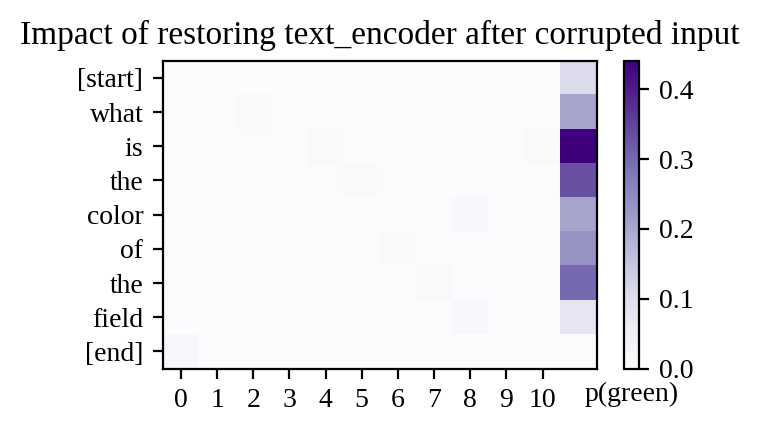

In [50]:
plot_map(temp_result,s)

In [ ]:
temp_result

{'scores': tensor([[0.8968, 0.8970, 0.8967, 0.8971, 0.8969, 0.8965, 0.8965, 0.8969, 0.8968,
          0.8966, 0.8966, 0.8964],
         [0.8974, 0.8969, 0.8966, 0.8971, 0.8972, 0.8970, 0.8970, 0.8970, 0.8965,
          0.8974, 0.8974, 0.8970],
         [0.8970, 0.8971, 0.8971, 0.8970, 0.8969, 0.8969, 0.8971, 0.8973, 0.8969,
          0.8966, 0.8968, 0.8974],
         [0.8974, 0.8973, 0.8966, 0.8961, 0.8967, 0.8968, 0.8966, 0.8967, 0.8973,
          0.8972, 0.8970, 0.8967],
         [0.8968, 0.8966, 0.8970, 0.8971, 0.8971, 0.8971, 0.8971, 0.8966, 0.8970,
          0.8970, 0.8967, 0.8972],
         [0.8960, 0.8972, 0.8974, 0.8967, 0.8968, 0.8969, 0.8974, 0.8969, 0.8975,
          0.8971, 0.8967, 0.8967],
         [0.8968, 0.8971, 0.8972, 0.8965, 0.8970, 0.8966, 0.8968, 0.8972, 0.8972,
          0.8965, 0.8967, 0.8967],
         [0.8977, 0.8970, 0.8969, 0.8966, 0.8977, 0.8976, 0.8971, 0.8968, 0.8965,
          0.8962, 0.8965, 0.8964],
         [0.8964, 0.8972, 0.8968, 0.8968, 0.8967, 0.89

In [ ]:
len(noises)

1

In [ ]:
def element_wise_average(*tensors):
    num_tensors = len(tensors)
    # Create an empty tensor of the same size as the input tensors
    average_tensor = np.zeros_like(tensors[0])

    # Sum the corresponding elements of the input tensors
    for tensor in tensors:
        average_tensor += tensor

    # Divide the summed tensor by the total number of input tensors
    average_tensor /= num_tensors

    return average_tensor

In [ ]:
ques=color_df['question_count'][25]

In [ ]:
print(ques.split())

['what', 'is', 'the', 'color', 'of', 'the', 'raincoat']


In [ ]:
color_df

,Unnamed: 0,final_image_id,train_image_id_count,question_count,answer_count
0,0,000000023004,23004,what is the color of the horses,brown
1,1,000000220218,220218,what is the color of the character,purple
2,2,000000491525,491525,what is the color of the dog,black
3,3,000000256565,256565,what is the color of the sign,red
4,4,000000351203,351203,what is the color of the leash,orange
...,...,...,...,...,...
13108,13108,000000463172,463172,what is the color of the bird,white
13109,13109,000000138368,138368,what is the color of the court,blue
13110,13110,000000381027,381027,what is the color of the inside,purple
13111,13111,000000411815,411815,what is the color of the field,green


In [ ]:
img_id_arr=[]
answer_arr=[]
question_arr=[]
for i in range(len(color_df['question_count'])):
  f_i_i=color_df['final_image_id'][i]
  answer=color_df['answer_count'][i]
  ques=color_df['question_count'][i]
  if len(ques.split())==7:
    question_arr.append(ques)
    answer_arr.append(answer)
    img_id_arr.append(f_i_i)




In [ ]:
color_df=pd.DataFrame()

In [ ]:
color_df['final_image_id']=img_id_arr
color_df['question_count']=question_arr
color_df['answer_count']=answer_arr

In [ ]:
color_df

,final_image_id,question_count,answer_count
0,000000023004,what is the color of the horses,brown
1,000000220218,what is the color of the character,purple
2,000000491525,what is the color of the dog,black
3,000000256565,what is the color of the sign,red
4,000000351203,what is the color of the leash,orange
...,...,...,...
13057,000000463172,what is the color of the bird,white
13058,000000138368,what is the color of the court,blue
13059,000000381027,what is the color of the inside,purple
13060,000000411815,what is the color of the field,green


In [ ]:
diff_text_enc=0
low_s_text_enc=0
diff_text_dec=0
low_s_text_dec=0
count=200
c1=0
c2=0
for i in range(count):
  image_id=color_df['final_image_id'][i]
  url=f"http://images.cocodataset.org/train2017/{image_id}.jpg"
  image=Image.open(requests.get(url, stream=True).raw)
  question=color_df['question_count'][i]
  #question=question.rstrip()
  result_temp=plot_average_hidden_flow(mt,new_model,image,question,'text_encoder')
  #print(result_temp['scores'])
  try:
    diff_text_enc+=result_temp['scores']
    low_s_text_enc+=result_temp['low_score']
  except:
    c1+=1
    continue

  result_temp_1=plot_average_hidden_flow(mt,new_model,image,question,'text_decoder')
  try:
    diff_text_dec+=result_temp_1['scores']
    low_s_text_dec+=result_temp_1['low_score']
  except:
    c2+=1
    continue
  if

In [ ]:
print(c1,c2)

34 0


In [ ]:
print(i)

25


In [ ]:
diff_text_dec

tensor([[0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8443, 0.8452,
         0.8455, 0.8465]])

In [ ]:
diff_text_enc=diff_text_enc/(count-34)
low_s_text_enc=low_s_text_enc/(count-34)
diff_text_dec=diff_text_dec/(count-34)
low_s_text_dec=low_s_text_dec/(count-34)

In [ ]:
diff_text_enc

tensor([[0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8443, 0.8444, 0.8445,
         0.8446, 0.8449, 0.8449],
        [0.8442, 0.8442, 0.8442, 0.8443, 0.8443, 0.8442, 0.8442, 0.8443, 0.8444,
         0.8444, 0.8448, 0.8447],
        [0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8441, 0.8441, 0.8442, 0.8444,
         0.8443, 0.8447, 0.8446],
        [0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8441, 0.8442, 0.8443, 0.8444,
         0.8444, 0.8448, 0.8447],
        [0.8443, 0.8443, 0.8443, 0.8443, 0.8443, 0.8443, 0.8443, 0.8444, 0.8445,
         0.8444, 0.8448, 0.8447],
        [0.8442, 0.8442, 0.8442, 0.8442, 0.8443, 0.8441, 0.8442, 0.8443, 0.8444,
         0.8445, 0.8448, 0.8448],
        [0.8442, 0.8442, 0.8442, 0.8442, 0.8443, 0.8441, 0.8442, 0.8443, 0.8445,
         0.8445, 0.8448, 0.8448],
        [0.8441, 0.8443, 0.8443, 0.8441, 0.8446, 0.8445, 0.8442, 0.8455, 0.8452,
         0.8451, 0.8453, 0.8450],
        [0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442, 0.8442,

In [ ]:
result={'differences_TE':diff_text_enc,'low_score_TE':low_s_text_enc,'differences_DE':diff_text_dec,'low_score_DE':low_s_text_dec}

In [ ]:
def avgnormal_heatmap(result,block_name, savepdf=None, title=None, xlabel=None, modelname=None):
  if block_name=='Question Encoder':
    avg_differences=result['differences_TE']
    avg_low_score=result['low_score_TE']
    answer = "QE"
    labels=['[Encode]','Q_token_1','Q_token_2','Q_token_3','Q_token_4','Q_token_5','Q_token_6','Q_token_7','[End]']
    block_name='text_encoder'
  elif block_name=='Answer Decoder':
    avg_differences=result['differences_DE']
    avg_low_score=result['low_score_DE']
    answer = "ANS"
    labels=['Decode']
    block_name='text_decoder'
  normalize_diffs=avg_differences-avg_low_score

  with plt.rc_context(rc={"font.family": "Liberation Serif"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            normalize_diffs,
            cmap={ "text_encoder": "Purples",'text_decoder':"Reds"}[block_name
            ],
            vmin=0.0,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(normalize_diffs))])
        ax.set_xticks([0.5 + i for i in range(0, normalize_diffs.shape[1] - 1, 1)])
        ax.set_xticklabels(list(range(0, normalize_diffs.shape[1] - 1, 1)))
        if not modelname:
            modelname = "BLIP"
        if block_name!=None:
              ax.set_yticklabels(labels)
              ax.set_title(f"Impact of restoring {block_name} after corrupted input")
            #ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({answer})", y=-0.16, fontsize=10)
        if savepdf:
            #os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [ ]:
def avg_heatmap(result,block_name, savepdf=None, title=None, xlabel=None, modelname=None):
  if block_name=='Question Encoder':
    avg_differences=result['differences_TE']
    avg_low_score=result['low_score_TE']
    answer = "QE"
    labels=['[Encode]','Q_token_1','Q_token_2','Q_token_3','Q_token_4','Q_token_5','Q_token_6','Q_token_7','[End]']
    block_name='text_encoder'
  elif block_name=='Answer Decoder':
    avg_differences=result['differences_DE']
    avg_low_score=result['low_score_DE']
    answer = "ANS"
    labels=['Decode']
    block_name='text_decoder'

  with plt.rc_context(rc={"font.family": "Liberation Mono"}):
        fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
        h = ax.pcolor(
            avg_differences,
            cmap={ "text_encoder": "Purples",'text_decoder':"Reds"}[block_name
            ],
            vmin=avg_low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(avg_differences))])
        ax.set_xticks([0.5 + i for i in range(0, avg_differences.shape[1] - 1, 1)])
        ax.set_xticklabels(list(range(0, avg_differences.shape[1] - 1, 1)))
        if not modelname:
            modelname = "BLIP"
        if block_name!=None:
              ax.set_yticklabels(labels)
              ax.set_title(f"Impact of restoring {block_name} after corrupted input")
            #ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({answer})", y=-0.16, fontsize=10)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

In [ ]:
avgnormal_heatmap(result,'Question Encoder','/content/466samples_normalized_causal_trace_Question_Encoder.pdf')

In [ ]:
avgnormal_heatmap(result,'Answer Decoder','/content/466samples_normalized_causal_trace_Answer_Decoder.pdf')